## Import relevent libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.stats
from scipy import stats

# Generating charts from data
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

## Reading the data

In [2]:
train = pd.read_csv('train.csv')
train.head().style.background_gradient(cmap = 'coolwarm')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S


In [3]:
test = pd.read_csv('test.csv')
test.head().style.background_gradient(cmap = 'coolwarm')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.829200,nan,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.000000,nan,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.687500,nan,Q
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.662500,nan,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.287500,nan,S


## Checking more information in the data sets

In [4]:
# Check the count of variables in the data sets
print('Train data set:', train.shape)
print('Test data set:', test.shape)

Train data set: (891, 12)
Test data set: (418, 11)


In [5]:
# Check the type of data stored in the data sets
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
# Explore the distribution of the target variable (Survivor)
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [9]:
# Combine the data sets
combined = pd.concat([train, test], sort = True)

Its not encouragable to combine train and test data sets as this is considered as data leakage.

In [10]:
combined.isna().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

## Explore Numerical data

In [11]:
train.describe().style.background_gradient(cmap = 'coolwarm')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
train.corr().style.background_gradient(cmap = 'coolwarm')

C:\Users\johns\AppData\Local\Temp\ipykernel_28492\2256105485.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr().style.background_gradient(cmap = 'coolwarm')


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Features that are strongly correlated cause noisy signal in the data during modelling. So, the strong correlated features have to be handled.

## Explore categorical data

In [14]:
train.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


Ticket has 681 unique features. To see how this feature can be made relevant can be challenging.

## Feature analysis

In [15]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index = False).mean().sort_values(by = 'Survived',
                                    ascending = False).style.background_gradient(cmap = 'coolwarm')

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [17]:
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index = False).mean().sort_values(by = 'Survived',
                                    ascending = False).style.background_gradient(cmap = 'coolwarm')

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [18]:
visDF = train.dropna()
visDF.shape

(183, 12)

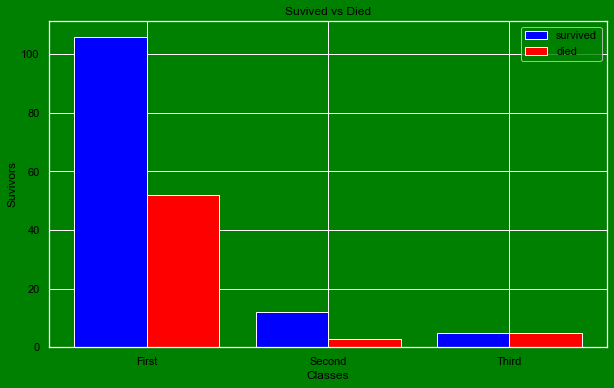

In [20]:
# Check the survivor rates by class
survivor = []
for i in visDF['Pclass'].unique():
    tempDF = visDF[visDF['Pclass'] == i]
    survived = len(tempDF[tempDF['Survived'] == 1]['Survived'])
    died = len(tempDF[tempDF['Survived'] == 0]['Survived'])
    survivor.append([i, survived, died])
survivor.sort()

X = ['First', 'Second', 'Third']
survived = [i[1] for i in survivor]
died = [i[2] for i in survivor]
X_axis = np.arange(len(X))

sns.set(rc = {'axes.facecolor': 'green', 'figure.facecolor': 'green'})
plt.figure(figsize = (10, 6))
plt.bar(X_axis - 0.2, survived, 0.4, label = 'survived', color = 'blue')
plt.bar(X_axis + 0.2, died, 0.4, label = 'died', color = 'red')
plt.xticks(X_axis, X, color = 'black')
plt.yticks(color = 'black')
plt.xlabel('Classes', color = 'black')
plt.ylabel('Suvivors', color = 'black')
plt.title('Suvived vs Died', color = 'black')
for i in plt.legend().get_texts():
    i.set_color('black')
plt.show()

In [21]:
# Explore the survivor rates by male
allAges = list(zip([i for i in visDF['Age']], [i for i in visDF['Survived']], [i for i in visDF['Sex']]))
allAges.sort()
males = [i for i in allAges if i[2] == 'male']
females = [i for i in allAges if i[2] == 'female']

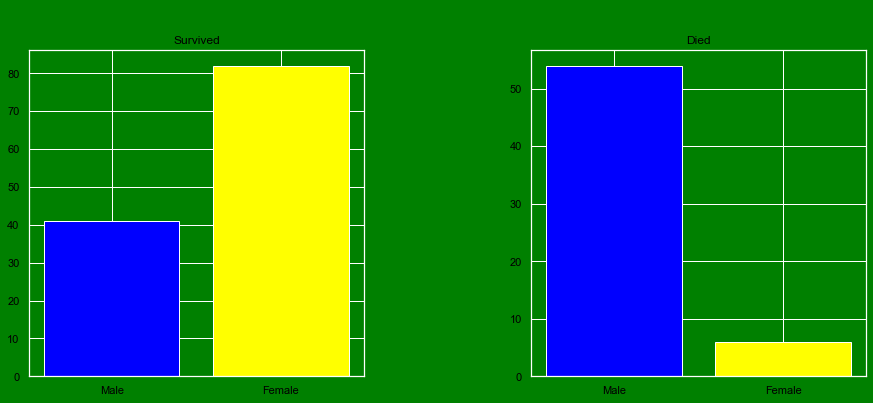

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Distribution of survivor rates by sex', color = 'green')
fig.set_figheight(6)
fig.set_figwidth(15)
fig.subplots_adjust(wspace = 0.5)

ax1.bar(['Male', 'Female'], [len([i[1] for i in males if i[1] == 1]), len([i[1] for i in females if i[1] == 1])], 
       color = ['blue', 'yellow'])
ax1.tick_params(axis = 'x', colors = 'black')
ax1.tick_params(axis = 'y', colors = 'black')
ax1.set_title('Survived', color = 'black')

ax2.bar(['Male', 'Female'], [len([i[1] for i in males if i[1] == 0]), len([i[1] for i in females if i[1] == 0])],
       color = ['blue', 'yellow'])
ax2.tick_params(axis = 'x', colors = 'black')
ax2.tick_params(axis = 'y', colors = 'black')
ax2.set_title('Died', color = 'black')

plt.show()

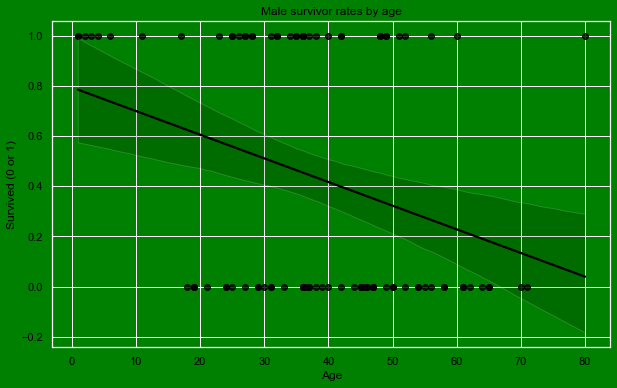

In [23]:
# Explore the survivor rates by age and sex
plt.figure(figsize = (10, 6))
sns.set(rc = {'axes.facecolor': 'green', 'figure.facecolor': 'green'})
sns.regplot(x = [i[0] for i in males], y = [i[1] for i in males], color = 'black')
plt.xticks(color = 'black')
plt.yticks(color = 'black')
plt.title(label = 'Male survivor rates by age', color = 'black')
plt.ylabel(ylabel = 'Survived (0 or 1)', color = 'black')
plt.xlabel(xlabel = 'Age', color = 'black')
plt.show()

For males, the survivor rates reduced as the age increased.

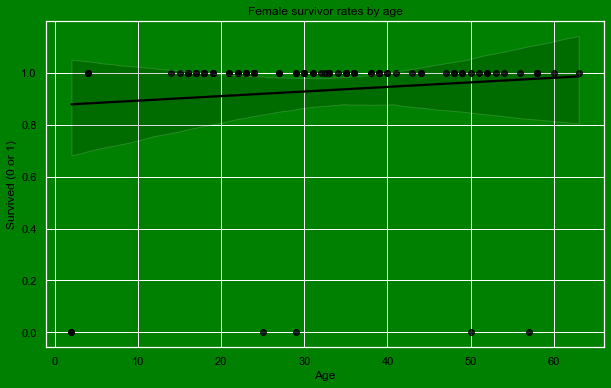

In [24]:
# Explore the survivor rates by age and sex
plt.figure(figsize = (10, 6))
sns.set(rc = {'axes.facecolor': 'green', 'figure.facecolor': 'green'})

sns.regplot(x = [i[0] for i in females], y = [i[1] for i in females], color =  'black')
plt.xticks(color = 'black')
plt.yticks(color = 'black')
plt.title(label = 'Female survivor rates by age', color = 'black')
plt.ylabel(ylabel = 'Survived (0 or 1)', color = 'black')
plt.xlabel(xlabel = 'Age', color = 'black')
plt.show()

The survivor rate was high in all ages for females.

## Data cleaning

In [25]:
# Drop ticket in the combined data set
combined = combined.drop(['Ticket'], axis = 1)

In [26]:
# Create feature 'title' for parsing passenger name
titles = ['Mr.','Mrs.','Miss.','Master.','Ms.','Sir.','Rev.','Dr.','Capt.','Don.','Mme.','Major.','Lady.',
          'Mlle.','Col.','Countess.','Jonkheer.','Dona.']
titleList = []
for name in [i.split(' ') for i in combined['Name']]:
    for title in titles:
        if title in name:
            titleList.append(title)

titleDict = {}
num = 0
for i in titles:
    titleDict.update({i:num})
    num += 1

conversions = []
for i in titleList:
    conversions.append(titleDict.get(i))

combined['Title'] = conversions

combined.head().style.background_gradient(cmap='coolwarm')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,22.000000,nan,S,7.250000,"Braund, Mr. Owen Harris",0,1,3,male,1,0.000000,0
1,38.000000,C85,C,71.283300,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,female,1,1.000000,1
2,26.000000,nan,S,7.925000,"Heikkinen, Miss. Laina",0,3,3,female,0,1.000000,2
3,35.000000,C123,S,53.100000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.000000,1
4,35.000000,nan,S,8.050000,"Allen, Mr. William Henry",0,5,3,male,0,0.000000,0


### Convert categorical data int numerical data

In [28]:
print(combined['Sex'].unique())
print(combined['Embarked'].unique())

['male' 'female']
['S' 'C' 'Q' nan]


In [30]:
# Sex to numerical order

combined.loc[combined['Sex'] == 'male', 'Sex'] = 0
combined.loc[combined['Sex'] == 'female', 'Sex'] = 1

# Replacing the missing value in Embarked with the most frequent one
combined.loc[combined['Embarked'].isna(), 'Embarked'] = stats.mode([ i 
             for i in combined['Embarked']])[0][0]


# Embark to numerical order
classifier = 0
for i in combined['Embarked'].unique():
    combined.loc[combined['Embarked'] == i, 'Embarked'] = classifier
    classifier += 1

# Type conversion
combined.Sex = combined.Sex.astype('int64')
combined.Embarked = combined.Embarked.astype('int64')
combined.head().style.background_gradient(cmap = 'coolwarm')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,22.000000,nan,0,7.250000,"Braund, Mr. Owen Harris",0,1,3,0,1,0.000000,0
1,38.000000,C85,1,71.283300,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,1,1,1.000000,1
2,26.000000,nan,0,7.925000,"Heikkinen, Miss. Laina",0,3,3,1,0,1.000000,2
3,35.000000,C123,0,53.100000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.000000,1
4,35.000000,nan,0,8.050000,"Allen, Mr. William Henry",0,5,3,0,0,0.000000,0


In [31]:
# First, replace the missing value with the median value
combined['Fare'].fillna(combined['Fare'].dropna().median(), inplace=True)
combined.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,22.0,NaN,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,0
1,38.0,C85,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,1
2,26.0,NaN,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,2
3,35.0,C123,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,1
4,35.0,NaN,0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,0


In [32]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1309 non-null   int64  
 3   Fare         1309 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   int64  
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Title        1309 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 132.9+ KB


### Handling missing values in Cabin

In [33]:
from sklearn.preprocessing import LabelEncoder
for feature in ['Cabin']:
    le = LabelEncoder()
    combined['Cabin_num'] = le.fit_transform(combined[feature].astype(str))

In [36]:
# Create indicator feature
combined['Cabin_ind'] = np.where(combined['Cabin'].isnull(), 0, 1)
combined

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Cabin_num,Cabin_ind
0,22.0,NaN,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,0,186,0
1,38.0,C85,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,1,106,1
2,26.0,NaN,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,2,186,0
3,35.0,C123,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,1,70,1
4,35.0,NaN,0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,0,186,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,NaN,0,8.0500,"Spector, Mr. Woolf",0,1305,3,0,0,NaN,0,186,0
414,39.0,C105,1,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,1,0,NaN,17,64,1
415,38.5,NaN,0,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,0,0,NaN,0,186,0
416,NaN,NaN,0,8.0500,"Ware, Mr. Frederick",0,1308,3,0,0,NaN,0,186,0
